# Movie 2 - AQP4 Distribution in migrating cell
## Load movie frames and perform segmentations

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import cv2
import seaborn as sns

movie2_path = "movies/movie2.avi"

In [3]:
# Find contours and get the largest contour to represent the entire structure
# Get bounding rectangle of leftmost and rightmost sides
def get_bounding_boxes(img):
    contours, hierarchy = cv2.findContours(img, 1, 2)
    c = max(contours, key=cv2.contourArea)
    
    leftBoundingRect = cv2.boundingRect(c[c[:, :, 0].argmin()])
    rightBoundingRect = cv2.boundingRect(c[c[:, :, 0].argmax()])

    return leftBoundingRect, rightBoundingRect, c

def check_sections(frame, check_size=10, min_mean_pixel=0.03):
    sections = []
    for c in range(0, frame.shape[1], check_size):
        mean_pixel = cv2.mean(frame[:,c:c+check_size])[0]
        #print("Current mean pixel:", mean_pixel)
        sections.append((mean_pixel, c, check_size))
    return sections

def get_left_side(frame, check_size=10, min_mean_pixel=0.03):
    for c in range(0, frame.shape[1], check_size):
        mean_pixel = cv2.mean(frame[:,c:c+check_size])[0]
        if mean_pixel > min_mean_pixel:
            return c
    return 0

def get_right_side(frame, check_size=10, min_mean_pixel=0.03):
    for c in range(frame.shape[1], 0, -(check_size)):
        mean_pixel = cv2.mean(frame[:,c-check_size:c])[0]
        if mean_pixel > min_mean_pixel:
            return c
    return 0


def get_segment_gaps(right_segments, edge=0, side='left', fill_size=2, space_from_edge=0):
    gaps = []
    for i in range(1,len(right_segments)):
        px, py, pw, ph = right_segments[i-1]
        nx, ny, nw, nh = right_segments[i]
        
        gx = edge+space_from_edge if side=='left' else edge-fill_size-space_from_edge
        gy = (py+ph)-1 if py+ph<=ny else (ny+nh)-1
        gw = fill_size
        gh = ny-(py+ph)+2 if py+ph<=ny else py-(ny+nh) +2

        print("Gap:", (gx, gy, gw, gh))
        gaps.append((gx, gy, gw, gh))
    return gaps

def get_mean_intensity(section):
    count = np.nonzero(section)[0].size
    mean = np.sum(section) / count
    #print(count, mean)
    return count, mean

outliers = []

## Calibrate and estimate parameters for segments

### Algorithm to find left and right edges
- Break the grayed frame into a contibuous sequence of rectangles of width 'check_size'.
- Calculate mean pixel values of each rectangle
- Return the first rectangle whose mean pixel value exceeds the threshold value 'min_mean_pixel'

### Applying the algorithm
- The appropriate width (thickness) of each edge is set to 40 for this movie.
- Some correction values may also be used to include all pixels at edges

In [166]:
print("Press 'q' to end video")

cap = cv2.VideoCapture(movie2_path)

# Get movie frame size
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH) + 0.5)
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT) + 0.5)
frame_size = (width,height)

# Initialize video writer to save segmented movie at 1 frame per second
writer = cv2.VideoWriter("movie2_segments.avi", cv2.VideoWriter_fourcc(*"XVID"), 1.0, frame_size)

frame_index = 0

data = []
while True:
    frame_index += 1
    success, frame = cap.read()

    if success and frame.size != 0:
        # Crop frame to remove text
        canvas = np.ones((frame.shape), np.uint8)
        canvas[35:90, :] = frame[35:90, :]
        isolated_cell = frame[35:90, :]
        canvas = cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB)
        
        # Blur to fill threshold gaps
        gray_frame = cv2.cvtColor(canvas, cv2.COLOR_BGR2GRAY)
        _, imgThreshold = cv2.threshold(gray_frame, 14, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        _, sepImgThreshold = cv2.threshold(gray_frame, 30, 255, cv2.THRESH_BINARY)
        _, imgThresh = cv2.threshold(gray_frame, 4, 255, cv2.THRESH_BINARY)
        blur_frame = cv2.GaussianBlur(imgThreshold, (7, 7), 0)

        contours, hierarchy = cv2.findContours(imgThresh, 1, 2)
        contour = max(contours, key=cv2.contourArea)
        c_x, c_y, c_w, c_h = cv2.boundingRect(contour)
        left_end = c_x
        right_end = c_x+c_w

        edge_width = 30

        left_min_threshold = 11
        right_min_threshold = 11

        edge_blur_value_x = 10
        edge_blur_value_y = 10

        left_section = gray_frame[:, c_x:c_x+edge_width]
        left_blur = cv2.blur(left_section, (edge_blur_value_x, edge_blur_value_y))
        _, left_thresh = cv2.threshold(left_blur, left_min_threshold, 255, cv2.THRESH_BINARY)

        right_section = gray_frame[:, c_x+c_w-edge_width:c_x+c_w]
        right_blur = cv2.blur(right_section, (edge_blur_value_x, edge_blur_value_y))
        _, right_thresh = cv2.threshold(right_blur, right_min_threshold, 255, cv2.THRESH_BINARY)

        #imgThreshold[:, c_x:c_x+edge_width] = left_thresh
        imgThreshold[:, c_x+c_w-edge_width:c_x+c_w] = right_thresh

        # noise removal
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1))
        bin_img = cv2.morphologyEx(imgThreshold, 
                                   cv2.MORPH_OPEN,
                                   kernel,
                                   iterations=2)

        sure_bg = cv2.dilate(bin_img, kernel, iterations=3)

        dist = cv2.distanceTransform(bin_img, cv2.DIST_L2, 0)

        ret, sure_fg = cv2.threshold(dist, 0.21 * dist.max(), 255, cv2.THRESH_BINARY)
        sure_fg = sure_fg.astype(np.uint8)

        unknown = cv2.subtract(sure_bg, sure_fg)

        # Marker labelling
        ret, markers = cv2.connectedComponents(sure_fg)

        # Add one to all labels so that background is not 0, but 1
        markers += 1
        # mark the region of unknown with zero
        markers[unknown == 255] = 0

        # create watershed markers
        markers = cv2.watershed(canvas, markers)

        labels = np.unique(markers)
        right_segments = []

        for label in labels[2:]:
            # Create a binary image in which only the area of the label is in the foreground 
            #and the rest of the image is in the background   
            target = np.where(markers == label, 255, 0).astype(np.uint8)
            x,y,w,h = cv2.boundingRect(target)

            min_segment_to_edge_distance = 22

            color = (255, 255, 255)
            if x-left_end <= min_segment_to_edge_distance:
                if len(canvas[markers == label]) > 10:
                    print(f'FRAME {frame_index} LEFT:', len(canvas[markers == label]))
                    count, mean = get_mean_intensity(canvas[markers == label])
                    data.append([frame_index, "L", count, mean])
    
                    canvas[markers == label] = [255, 0, 0]
                    cv2.putText(canvas, "L", (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.35, color, 1, cv2.LINE_AA)
            elif right_end-(w+x) <= min_segment_to_edge_distance:
                count, mean = get_mean_intensity(canvas[markers == label])
                data.append([frame_index,"R", count, mean])

                canvas[markers == label] = [255, 255, 0]
                cv2.putText(canvas, "R", (x+w, y+h), cv2.FONT_HERSHEY_SIMPLEX, 0.35, color, 1, cv2.LINE_AA)
                #right_rect = cv2.rectangle(canvas,(x,y),(x+w,y+h),(0,0,255),1)
                right_segments.append((x, y, w, h))
            else:
                rand_color = [0,0,255]
                canvas[markers == label] = rand_color

        rect = cv2.rectangle(canvas, (c_x,c_y), (c_x+c_w,c_y+c_h), color, 1)
        writer.write(canvas)

        concat_img = cv2.vconcat([sepImgThreshold, gray_frame, blur_frame])

        cv2.imshow("Movie 2", right_blur)

    # 1 frame per second
    if cv2.waitKey(2000) & 0xFF == ord('q'):
        break

cap.release()
writer.release()
cv2.destroyAllWindows()

Press 'q' to end video
FRAME 1 LEFT: 263
FRAME 2 LEFT: 304


## Mean pixels at edge as fluorescent intensity values
- The mean pixel values obtained with 'cv2.mean()' are used as fluorescent intensity values
- Each value in each frame is appended to the 'fluorescent_intensities' list which will be converted to a Pandas dataframe for analysis
- The position of the trailing edge (left side) is also included to represent the position of the cell in each frame.
- The relative change in position will be used as displacement and for calculating velocity
- The time interval between each frame is 10 minutes.

In [160]:
print("Press 'q' to end video")
cap = cv2.VideoCapture(movie2_path)


# Get movie frame size
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH) + 0.5)
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT) + 0.5)
frame_size = (width, height)

# Initialize video writer to save segmented movie at 1 frame per second
writer = cv2.VideoWriter("output2.avi", cv2.VideoWriter_fourcc(*"XVID"), 1.0, frame_size)

frame_index = 0 # Track frame number for fluorescent intensity table

fluorescent_intensities = []

while True:
    frame_index += 1
    success, frame = cap.read()

    if success and frame.size != 0:
        # Crop frame to remove text
        canvas = np.ones((frame.shape), np.uint8)
        canvas[35:90, :] = frame[35:90, :]
        
        # Blur to fill threshold gaps
        gray_frame = cv2.cvtColor(canvas, cv2.COLOR_BGR2GRAY)
        _, imgThreshold = cv2.threshold(gray_frame, 13.5, 255, cv2.THRESH_BINARY)
        _, sepImgThreshold = cv2.threshold(gray_frame, 50, 255, cv2.THRESH_BINARY)
        blur_frame = cv2.GaussianBlur(imgThreshold, (7,7), 0)

        edge_width = 10
        
        left_side = get_left_side(blur_frame, check_size=edge_width, min_mean_pixel=9)
        right_side = get_right_side(blur_frame, check_size=edge_width, min_mean_pixel=9)
        
        left_side_thickness = 40
        right_side_thickness = 40
        left_side_offset_correction = 0
        right_side_offset_correction = 0

        cv2.rectangle(canvas, (left_side-left_side_offset_correction,35), 
                              (left_side+left_side_thickness+left_side_offset_correction, 90), 
                              (255, 255, 255), 1)

        # Right edge
        cv2.rectangle(canvas, (right_side-right_side_thickness,35), 
                              (right_side, 90), 
                              (255, 255, 0), 1)

        right_section_mask = sepImgThreshold[35:90, right_side-right_side_thickness:right_side]
        right_section = imgThreshold[35:90, right_side-right_side_thickness:right_side]
        #right_blur = cv2.blur(right_section, (edge_blur_value_x, edge_blur_value_y))
        #right_rect = cv2.rectangle(canvas,(x,y),(x+w,y+h),(0,0,255),1)

        # Entire cell
        #cv2.rectangle(canvas, (left_side-left_side_offset_correction,35),
        #                      (right_side, 90), 
        #                      (0, 255, 255), 1)

        # Calculate mean intensity at trailing edge
        trailing_edge = gray_frame[35:90, left_side-left_side_offset_correction:left_side+left_side_thickness+left_side_offset_correction]
        trailing_edge_intensity = cv2.mean(trailing_edge)
        print("Trailing Edge:", trailing_edge_intensity)

        # Calculate mean intensity at leading edge
        leading_edge = gray_frame[35:90, right_side-right_side_thickness:right_side]
        leading_edge_intensity = cv2.mean(leading_edge)
        print("Leading Edge:", leading_edge_intensity)

        # Append intensity data to list
        fluorescent_intensities.append([frame_index, trailing_edge_intensity[0], leading_edge_intensity[0], (frame_index*10)-10, left_side])

        writer.write(canvas)
        #sepImgThreshold

        cv2.imshow("Movie 2: AQP4 imaging segments", leading_edge)

    # 1 frame per second
    if cv2.waitKey(1000) & 0xFF == ord('q'):
        break

cap.release()
writer.release()
cv2.destroyAllWindows()

Press 'q' to end video
Trailing Edge: (17.98318181818182, 0.0, 0.0, 0.0)
Leading Edge: (12.114090909090908, 0.0, 0.0, 0.0)
Trailing Edge: (19.029545454545456, 0.0, 0.0, 0.0)
Leading Edge: (9.579090909090908, 0.0, 0.0, 0.0)
Trailing Edge: (17.314090909090908, 0.0, 0.0, 0.0)
Leading Edge: (10.836363636363636, 0.0, 0.0, 0.0)
Trailing Edge: (20.951818181818183, 0.0, 0.0, 0.0)
Leading Edge: (13.758636363636363, 0.0, 0.0, 0.0)
Trailing Edge: (20.283636363636365, 0.0, 0.0, 0.0)
Leading Edge: (10.599545454545455, 0.0, 0.0, 0.0)
Trailing Edge: (17.777272727272727, 0.0, 0.0, 0.0)
Leading Edge: (11.095454545454546, 0.0, 0.0, 0.0)
Trailing Edge: (19.937272727272727, 0.0, 0.0, 0.0)
Leading Edge: (10.251818181818182, 0.0, 0.0, 0.0)
Trailing Edge: (19.31, 0.0, 0.0, 0.0)
Leading Edge: (12.096818181818183, 0.0, 0.0, 0.0)
Trailing Edge: (19.420909090909092, 0.0, 0.0, 0.0)
Leading Edge: (12.293636363636363, 0.0, 0.0, 0.0)
Trailing Edge: (21.101363636363637, 0.0, 0.0, 0.0)
Leading Edge: (11.91636363636363

## Calculate Displacements and Velocities

In [17]:
intensity_dataframe = pd.DataFrame(fluorescent_intensities, columns =  ["Frame", "Trailing", "Leading","Time","Position"])
# Displacement = All Positions - Starting position
intensity_dataframe["Displacement"] = intensity_dataframe["Position"] - intensity_dataframe["Position"][0]
# Time from minutes to seconds
intensity_dataframe["Time"] = intensity_dataframe["Time"] * 60
# Calculate velocity
# Velocity = displacement / time in seconds
intensity_dataframe["Displacement"].astype('float64')
intensity_dataframe["Time"].astype('float64')

intensity_dataframe["Average Velocity"] = intensity_dataframe["Displacement"] / intensity_dataframe["Time"]

instantaneous_distances = []
for idx in range(len(intensity_dataframe["Displacement"])):
    if idx > 0:
        instantaneous_distances.append(intensity_dataframe["Displacement"][idx]-intensity_dataframe["Displacement"][idx-1])
    else:
        instantaneous_distances.append(intensity_dataframe["Displacement"][idx])
        
intensity_dataframe["Instantaneous Displacement"] = pd.Series(instantaneous_distances)
intensity_dataframe["Instantaneous Velocity"] = intensity_dataframe["Instantaneous Displacement"] / 600

intensity_dataframe = intensity_dataframe.fillna(0)
intensity_dataframe

,Frame,Trailing,Leading,Time,Position,Displacement,Average Velocity,Instantaneous Displacement,Instantaneous Velocity
0,1,17.983182,12.114091,0,0,0,0.000000,0,0.000000
1,2,19.029545,9.579091,600,20,20,0.033333,20,0.033333
2,3,17.314091,10.836364,1200,40,40,0.033333,20,0.033333
3,4,20.951818,13.758636,1800,70,70,0.038889,30,0.050000
4,5,20.283636,10.599545,2400,80,80,0.033333,10,0.016667
5,6,17.777273,11.095455,3000,80,80,0.026667,0,0.000000
6,7,19.937273,10.251818,3600,90,90,0.025000,10,0.016667
7,8,19.310000,12.096818,4200,110,110,0.026190,20,0.033333
8,9,19.420909,12.293636,4800,120,120,0.025000,10,0.016667
9,10,21.101364,11.916364,5400,130,130,0.024074,10,0.016667


## Plot fluorescent intensities

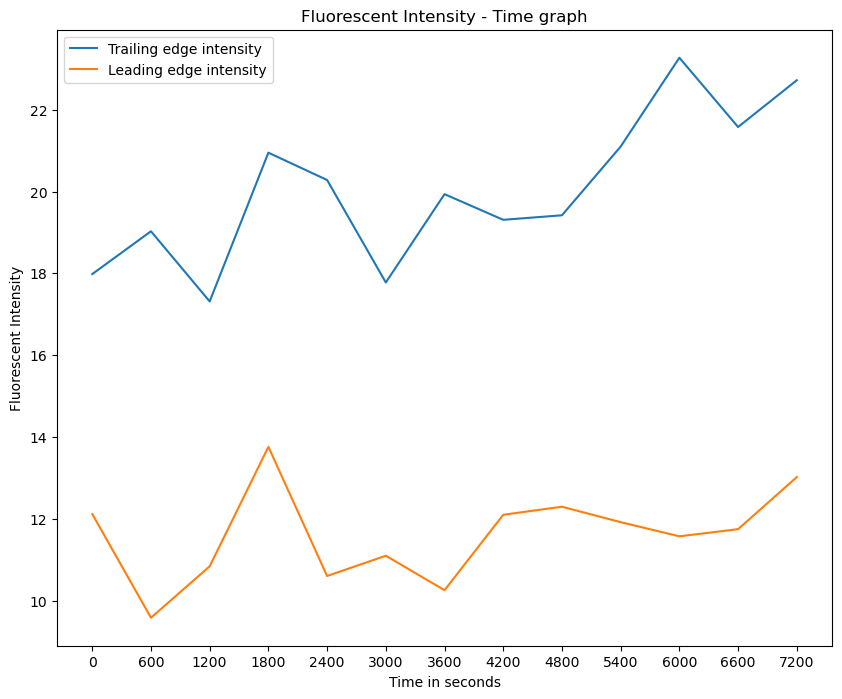

In [20]:
plt.figure(figsize=(10,8))
plt.plot(intensity_dataframe.Time, intensity_dataframe.Trailing, label="Trailing edge intensity")
plt.plot(intensity_dataframe.Time, intensity_dataframe.Leading, label="Leading edge intensity")

plt.title("Fluorescent Intensity - Time graph")
plt.ylabel("Fluorescent Intensity")
plt.xlabel("Time in seconds")
plt.legend()
plt.xticks(intensity_dataframe.Time)
plt.show()

- Fluorescent intensity at trailing edge exceeds that at leading edge in all frames

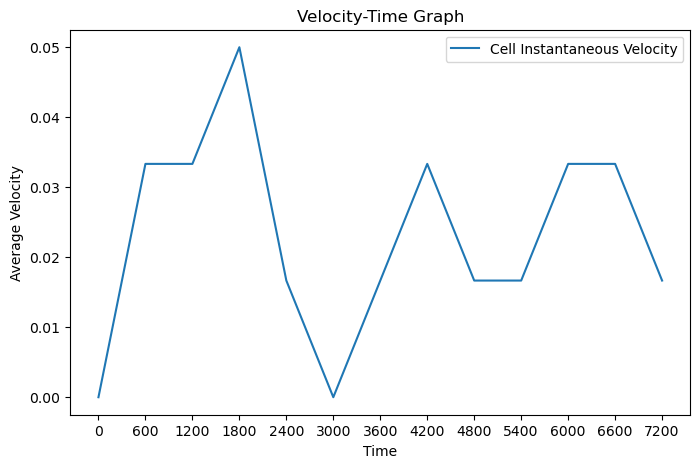

In [23]:
plt.figure(figsize=(8,5))
plt.plot(intensity_dataframe.Time, intensity_dataframe["Instantaneous Velocity"], label="Cell Instantaneous Velocity")

plt.title("Velocity-Time Graph")
plt.ylabel("Average Velocity")
plt.xlabel("Time")
plt.legend()
plt.xticks(intensity_dataframe.Time)
plt.show()

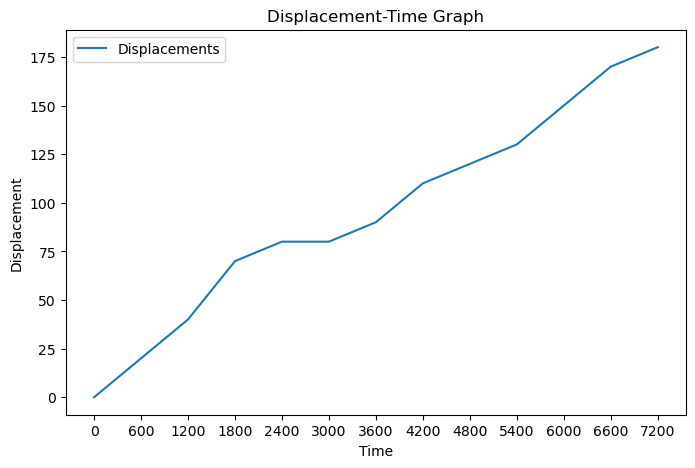

In [27]:
plt.figure(figsize=(8,5))
plt.plot(intensity_dataframe.Time, intensity_dataframe["Displacement"], label="Displacements")

plt.title("Displacement-Time Graph")
plt.ylabel("Displacement")
plt.xlabel("Time")
plt.legend()
plt.xticks(intensity_dataframe.Time)
plt.show()

- Cell continues to move forward over time

## Fluorescent intensity analysis
### 1. Box plot

In [31]:
fluorescent_intensity_data = intensity_dataframe[['Trailing','Leading']]
fluorescent_intensity_data.describe()

,Trailing,Leading
count,13.000000,13.000000
mean,20.052797,11.605734
std,1.843328,1.137477
min,17.314091,9.579091
25%,19.029545,10.836364
50%,19.937273,11.744545
75%,21.101364,12.114091
max,23.274091,13.758636


<Axes: title={'center': 'Boxplot of Mean Fluorescent intensity at Leading and Trailing Edges'}>

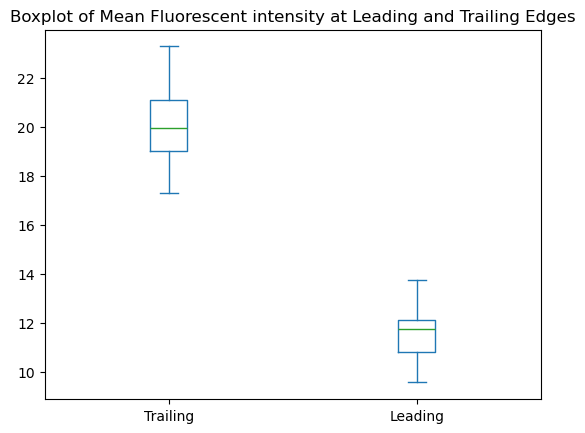

In [33]:
fluorescent_intensity_data.plot(kind="box", title="Boxplot of Mean Fluorescent intensity at Leading and Trailing Edges")

## 2. Analysis of Variance

In [36]:
from scipy import stats
f, p = stats.f_oneway(fluorescent_intensity_data['Trailing'],fluorescent_intensity_data['Leading'])
print(f,p)

197.7076020465485 4.39897896633995e-13


#### Inference from ANOVA
The F-statistic and the P-value were approximately 197.708 and 4.399e-13 respectively.
This implies a significant difference between trailing and leading mean fluorescent intensities.
That is, significantly more AQP4 proteins localize at the trailing edge than the leading edge.